# **Beamforming**

In this notebook we will perform beamforming from scratch. We will base the code from the PySDR [tutorial](https://pysdr.org/content/doa.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Signal Model

### Construct a 1D Sinusoidal signal with Additive Whie Gaussian Noise (AWGN)

In [133]:
sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6 # signal frequency

# create signal with AWG Noise
awgn = np.random.normal(0, 0.1, N) + 1j*np.random.normal(0, 0.1, N)
s_tx = np.exp(2j * np.pi * f_tone * t) + awgn

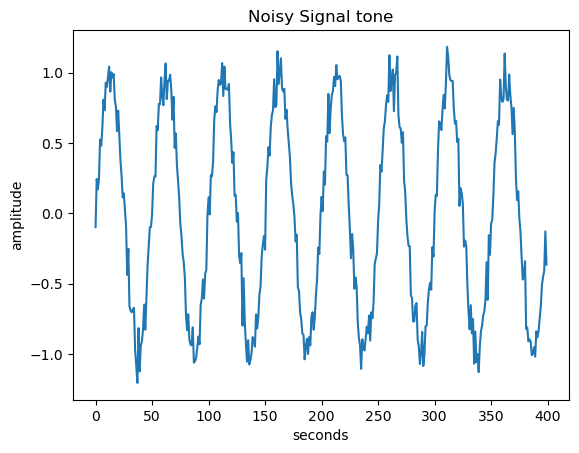

In [134]:
plt.plot(s_tx[:400].imag);
plt.title("Noisy Signal tone")
plt.xlabel("seconds")
plt.ylabel("amplitude");

### Construct array and Compute the signal Steering Vector

We will specify the number of array elements and their spacing and then compute the steering vector for the known signal direction

The steering vector contains each elements response to the incoming signal

In [135]:
d = 0.5 # half wavelength spacing
Nr = 3
theta_degrees = 25 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians

steering_vector = lambda theta, Nr, d =d : np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) 
v_signal = steering_vector(theta, Nr)[:, None]

### Process the signal through the array

Now let's simulate what happens when the signal impings on the array. To do this we will (matrix) multiply the signal's steering vector with the signal. We will also add some AWG noise to each element since that's what happens in real life.

In [136]:
# X = tx[:, None] @ v_signal[:, None].conj().T + np.random.normal(0, 0.1, (N, Nr))
awgn = np.random.normal(0, 0.1, (N, Nr)) + 1j*np.random.normal(0, 0.1, (N, Nr))
X = (s_tx[:, None] @ v_signal.T) + awgn

In [137]:
v_signal.T.shape, awgn.shape

((1, 3), (10000, 3))

In [138]:
s_tx.shape, v_signal.shape, X.shape

((10000,), (3, 1), (10000, 3))

Now we plot the received signal. Notice how the more off center the signal is, the more offset the received signal is at each element

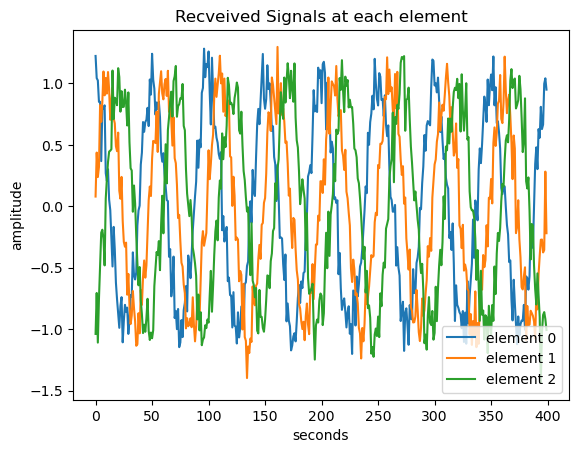

In [139]:
plt.plot(np.real(X[0:400, :]), label=[f"element {i}" for i in range(Nr)]);
plt.legend();

plt.title("Recveived Signals at each element")
plt.xlabel("seconds")
plt.ylabel("amplitude");

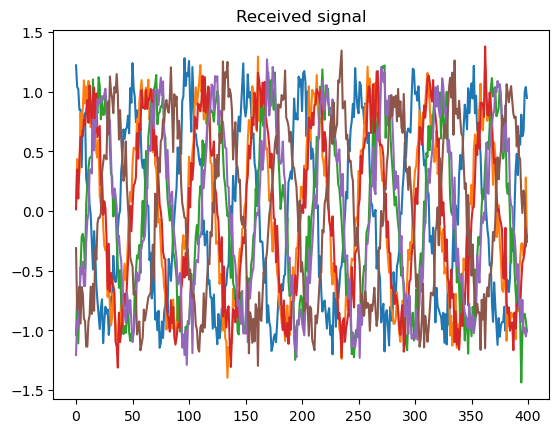

In [140]:
plt.plot(np.real(X[0:400, :]), label=[f"in phase element {i}" for i in range(Nr)]); # in phase
plt.plot(np.imag(X[0:400, :]), label=[f"quadrature element {i}" for i in range(Nr)]); # quadrature
# plt.legend(); 

plt.title("Received signal");

## Beamforming

Now this is clearly cheating, since we knew the direction of arrival. Now let's process the recevied signal X assuming that we don't know the angle of arrival. How would we do this?

We can sweep the Steering Vector across many angles and take the inner product of each Steering Vector with the recevied signal. Then we can see which resulting inner product results in a signal with the largest peak. The inner product will tell us which angle is the most correleted to the signals direction of arrival.

In [141]:
# collection angles to process
thetas = np.arange(-90, 90 + 0.1, 0.1)

outputs = []
responses = []
for theta in thetas:
    theta *= np.pi/180
    w = steering_vector(theta, Nr) # Steering Vector
    # y = w.conj().T @ X.T
    y = (X @ w.conj()) / Nr
    response = 10*np.log10(np.var(y))

    outputs.append(y)
    responses.append(response)

responses -= np.max(responses) # normalize (optional)

# obtain angle that gave us the max value
angle_idx = np.argmax(responses)
aoa = thetas[angle_idx]
s_hat = outputs[angle_idx]

aoa

24.999999999993463

In [142]:
w.shape, X.shape, w.shape

((3,), (10000, 3), (3,))

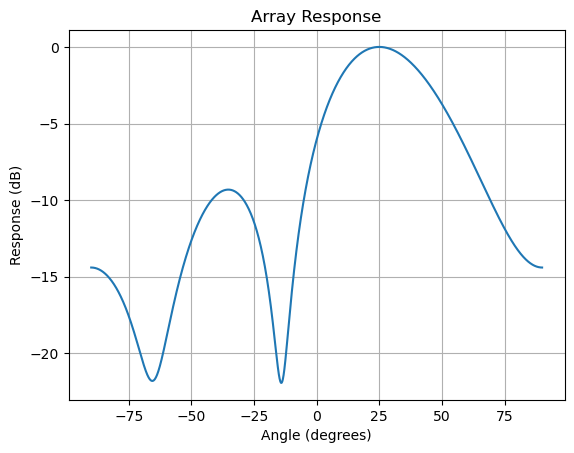

In [193]:
plt.plot(thetas, responses)
plt.grid();
plt.title("Array Response")
plt.xlabel("Angle (degrees)")
plt.ylabel("Response (dB)");

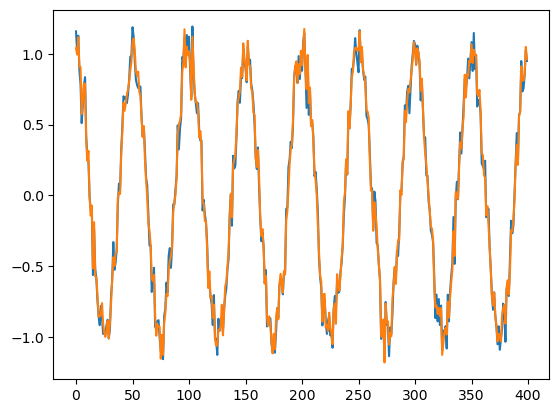

In [151]:
plt.plot(outputs[angle_idx].real[:400])
plt.plot(s_tx.real[:400]);

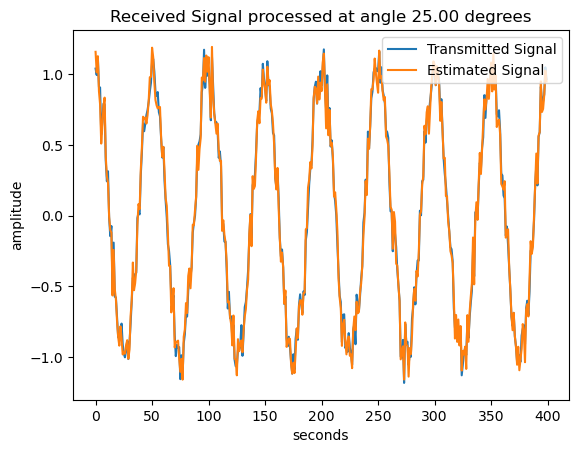

In [185]:
plt.plot(s_tx.real[:400], label="Transmitted Signal");
plt.plot(outputs[angle_idx].real[:400], label="Estimated Signal")

plt.legend()

plt.title(f"Received Signal processed at angle {aoa:.2f} degrees")
plt.xlabel("seconds")
plt.ylabel("amplitude");

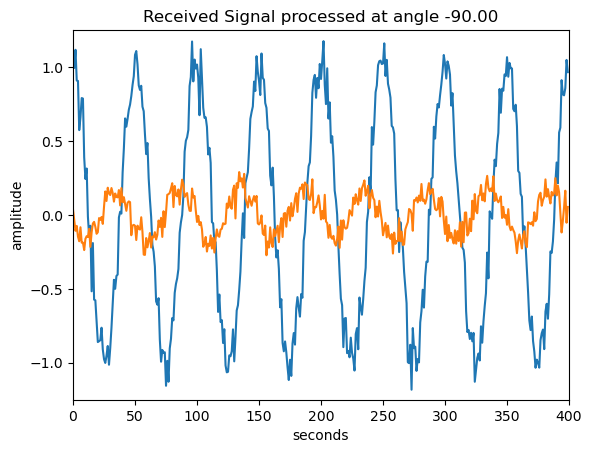

In [195]:
import matplotlib.animation as animation


figure = plt.figure()
 
# creating a plot
lines_plotted = plt.plot([])     
line_plotted = lines_plotted[0]

lines_plotted_2 = plt.plot([])     
line_plotted_2 = lines_plotted_2[0]
 
# Need to have x and y limits for plots to show
plt.xlim(0, 400)  
plt.ylim(-1.25, 1.25);

plt.title(f"Received Signal processed at angle {theta}")
plt.xlabel("seconds")
plt.ylabel("amplitude");



def animate(i):

    theta = thetas[i]
    y = outputs[i]

    # update title
    plt.title(f"Received Signal processed at angle {theta:.2f}")
 
    # line is set with new values of x and y
    line_plotted.set_data((np.arange(0, 400), s_tx.real[:400]))
    line_plotted_2.set_data((np.arange(0, 400), y.real[:400]))
    

ani = animation.FuncAnimation(figure, animate, repeat=True,
                              frames=np.arange(0, len(thetas), 3), # len(thetas)
                            )

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=40,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('ds_sigals_2.gif', writer=writer)